# Australian Wine Sales

With known monthly sales of Australian wine in thousands of liters from January 1980 to July 1995, it is necessary to build a forecast for the next three years.

In [4]:
import warnings
from itertools import product

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

In [6]:
%matplotlib inline

In [7]:
def invboxcox(y, lmd):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmd*y + 1) / lmd))

In [8]:
wine = pd.read_csv(
    filepath_or_buffer='monthly-australian-wine-sales.csv',
    index_col=['month'], 
    parse_dates=['month'], 
    dayfirst=True
)
wine.sales = wine.sales * 1000

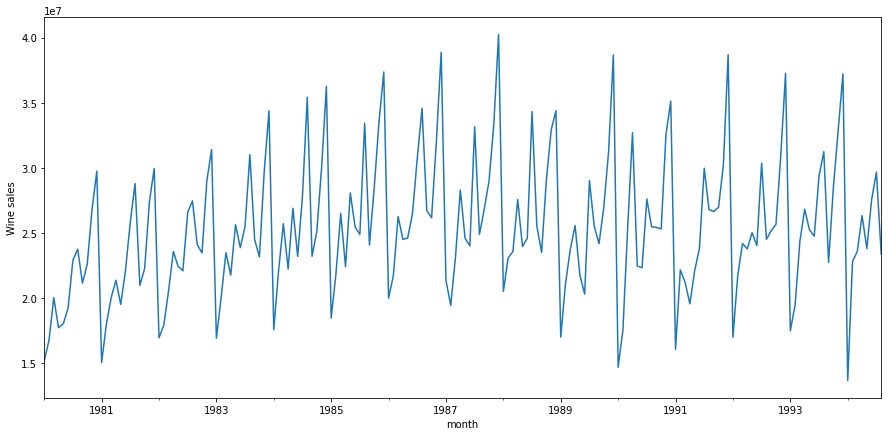

In [9]:
plt.figure(figsize=(15, 7))
wine.sales.plot()
plt.ylabel('Wine sales')
plt.show()

Stationarity check and STL-decomposition of the series:

In [10]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(wine.sales)[1])

Dickey–Fuller test: p=0.051161


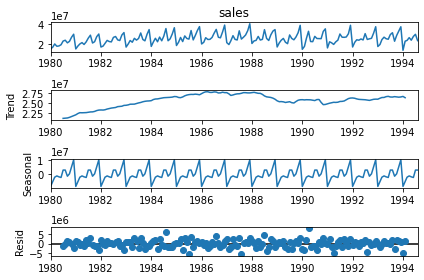

In [11]:
sm.tsa.seasonal_decompose(wine.sales).plot()
plt.show()

### Dispersion stabilisation

Box-Cox transformation to stabilise the variance:

Optimal Box-Cox transformation parameter:: 0.236675
Dickey–Fuller test: p=0.029565


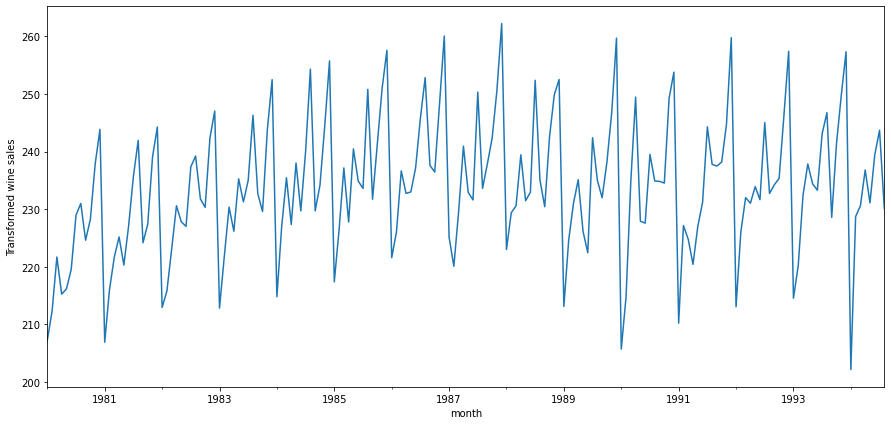

In [12]:
wine['sales_box'], lmbda = stats.boxcox(wine.sales)
plt.figure(figsize=(15,7))
wine.sales_box.plot()
plt.ylabel('Transformed wine sales')
print("Optimal Box-Cox transformation parameter:: %f" % lmbda)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(wine.sales_box)[1])

### Stationarity

The Dickey-Fuller criterion rejects the hypothesis of nonstationarity, but visually the data shows a trend. Let's try seasonal differentiation; let's do STL decomposition on the differentiated series and check the stationarity:

In [13]:
wine['sales_box_diff'] = wine.sales_box - wine.sales_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(wine.sales_box_diff[12:])[1])

Dickey–Fuller test: p=0.128317


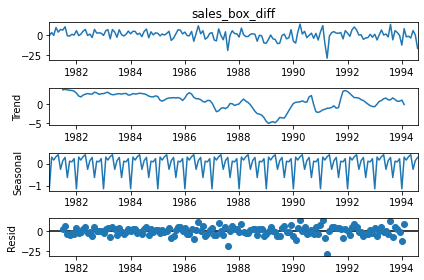

In [14]:
sm.tsa.seasonal_decompose(wine.sales_box_diff[12:]).plot()
plt.show()

The Dickey-Fuller criterion does not reject the hypothesis of nonstationarity, and it was not possible to completely get rid of the trend. Let's try to add some more common differentiation:

In [15]:
wine['sales_box_diff2'] = wine.sales_box_diff - wine.sales_box_diff.shift(1)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(wine.sales_box_diff2[13:])[1])

Dickey–Fuller test: p=0.000002


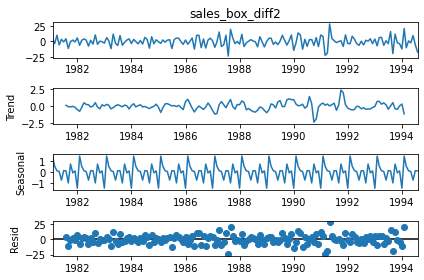

In [16]:
sm.tsa.seasonal_decompose(wine.sales_box_diff2[13:]).plot()   
plt.show()

The hypothesis of nonstationarity is rejected, and visually the series looks better - there is no more trend.

## Model selection

ACF and PACF of the resulting series:

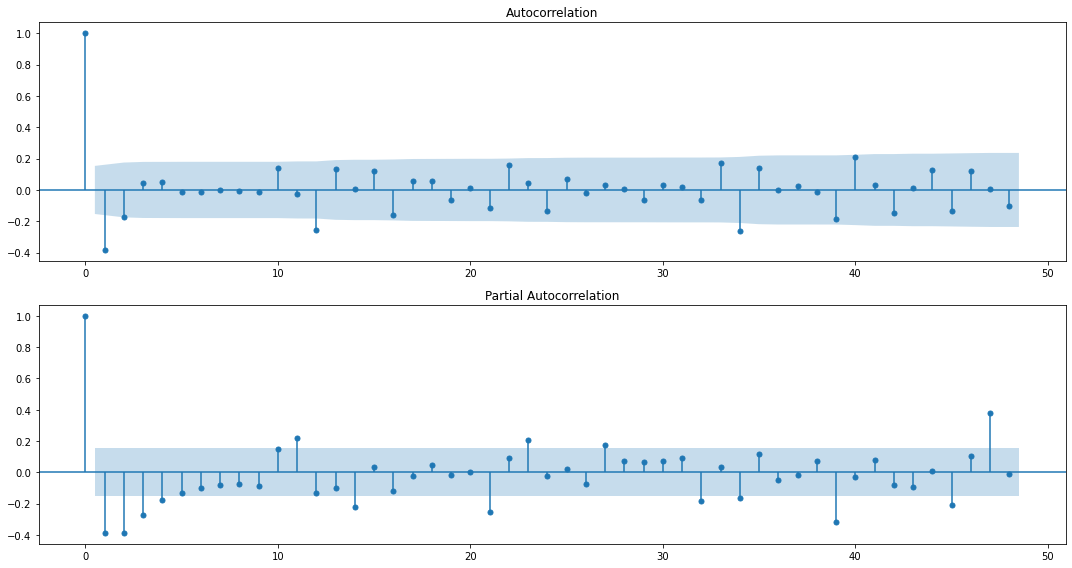

In [17]:
plt.figure(figsize=(15, 8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wine.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wine.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

Initial approximations: Q = 1, q = 2, P = 1, p = 4

In [18]:
ps = range(5)
d=1
qs = range(3)
Ps = range(2)
D=1
Qs = range(2)

In [19]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [20]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except is needed because the model is not trained on some sets of parameters
    try:
        model=sm.tsa.statespace.SARIMAX(wine.sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=True)
    # output the parameters on which the model is not trained and go to the next set
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    # save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 50.7 s, sys: 998 ms, total: 51.7 s
Wall time: 18.1 s


In [21]:
result_table = pd.DataFrame(results, columns=['parameters', 'aic'])
result_table.sort_values(by='aic', ascending=True).head()

/Users/vladislavklyuev/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,parameters,aic
21,"(1, 2, 0, 1)",1006.024314
29,"(2, 1, 0, 1)",1007.801388
31,"(2, 1, 1, 1)",1008.786373
45,"(3, 2, 0, 1)",1009.167726
33,"(2, 2, 0, 1)",1009.284102


Best model:

In [22]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            sales_box   No. Observations:                  176
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -498.012
Date:                              Fri, 12 Mar 2021   AIC                           1006.024
Time:                                      12:15:30   BIC                           1021.493
Sample:                                  01-01-1980   HQIC                          1012.304
                                       - 08-01-1994                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9103      0.053     17.037      0.000       0.806       1.015
ma.L1         -1.93

/Users/vladislavklyuev/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Residuals:

In [23]:
print("Student test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Student test: p=0.384982
Dickey–Fuller test: p=0.000000


/Users/vladislavklyuev/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/vladislavklyuev/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


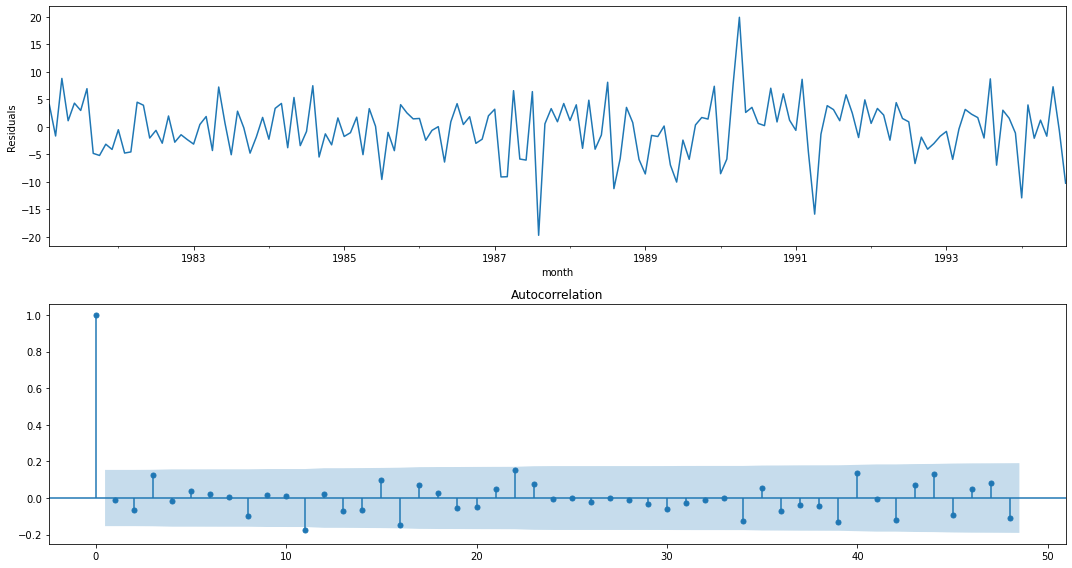

In [24]:
plt.figure(figsize=(15,8))

ax = plt.subplot(211)
best_model.resid[13:].plot(ax=ax)
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

plt.tight_layout()
plt.show()

The residuals are unbiased (confirmed by the Student's test), stationary (confirmed by the Dickey-Fuller test and visually), non-autocorrelated (confirmed by the Ljung-Box test and the correlogram). How well the model describes the data:

/Users/vladislavklyuev/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


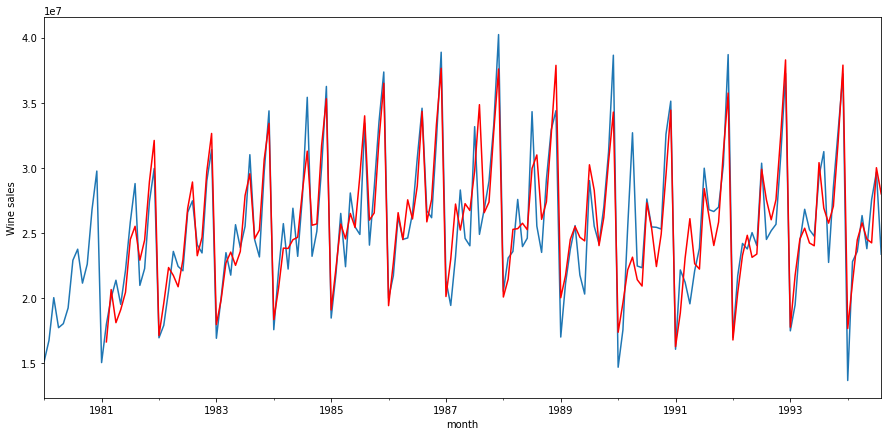

In [25]:
wine['model'] = invboxcox(best_model.fittedvalues, lmbda)

plt.figure(figsize=(15,7))
wine.sales.plot()
wine.model[13:].plot(color='r')
plt.ylabel('Wine sales')
plt.show()

### Prediction

In [26]:
start, end = "1994-09-01", "1997-08-01"

/Users/vladislavklyuev/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
wine2 = wine[['sales']]
date_range = pd.date_range(start=start, end=end, freq="MS")
future = pd.DataFrame(index=date_range, columns=wine2.columns)
wine2 = pd.concat([wine2, future])

In [28]:
wine2['forecast'] = invboxcox(best_model.predict(start=start, end=end), lmbda)

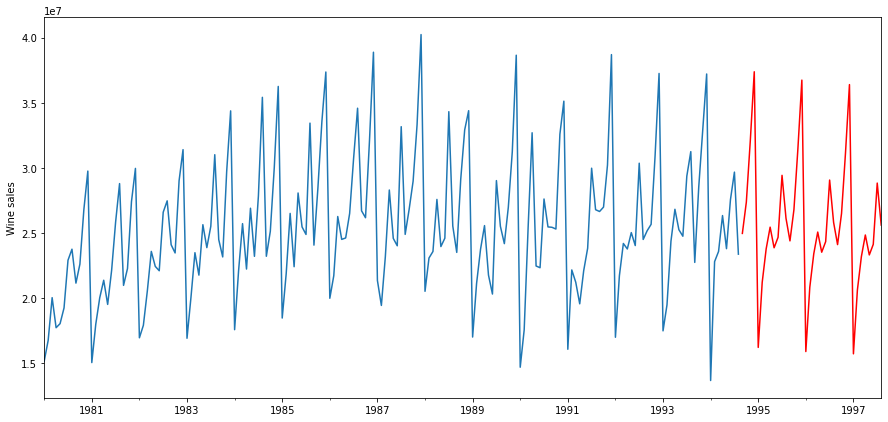

In [29]:
plt.figure(figsize=(15,7))
wine2.sales.plot()
wine2.forecast.plot(color='r')
plt.ylabel('Wine sales')
plt.show()